# Simulation 01

# Built-in R functions - Inverse cdf method - Intro Stan

# Josep Fortiana  2022-02-28

***
###### LaTeX macros
$\def\prob{P}$
$\def\borel{\operatorname{Borel}}$
$\def\cE{\cal E}$
$\def\cP{\cal P}$
$\def\R{\mathbb{R}}$ 
$\def\N{\mathbb{N}}$
$\def\Z{\mathbb{Z}}$
$\def\Ee{\operatorname{E}}$
$\def\va{\text{v.a.}}$
$\def\var{\operatorname{var}}$
$\def\cov{\operatorname{cov}}$
$\def\cor{\operatorname{cor}}$
$\def\binomdist{\operatorname{Binom}}$
$\def\berndist{\operatorname{Ber}}$
$\def\gammadist{\operatorname{Gamma}}$
$\def\hyperdist{\operatorname{Hypergeom}}$
$\def\hypergeomdist{\operatorname{Hypergeom}}$
$\def\poissondist{\operatorname{Poisson}}$
$\def\geomdist{\operatorname{Geom}}$
$\def\normaldist{\operatorname{N}}$
$\def\unifdist{\operatorname{Unif}}$
$\DeclareMathOperator{\indica}{\mathbb{1}}$
$\def\CondTo{\mathbin{|\mskip0.5mu}}$
$\DeclareMathOperator{\indep}{\perp\negthickspace\negthinspace\perp}$
***

# Exercise 05

Design, write the code for a generator of random numbers for the distribution with a triangular pdf described below, based on the inverse cdf transformation method. Assess the quality of your generator by comparing a histogram of generated with the theoretical pdf.

$$
    f(x)=\left\{\begin{array}{lll}
        0,       &\text{ if }    &x\notin[0,1]\\[0.2cm]
        4\,x,    &\text{ if }    &0\leq x<1/2,\\[0.2cm]
        4-4\,x,  &\text{ if }    &1/2\leq x<1,
    \end{array}\right.\mskip50mu x\in\R.
$$

# Solution 05 - Stan version

In [1]:
f<-function(x){
    ifelse(x<0,0,ifelse(x<0.5,4*x,ifelse(x<1,4-4*x,0)))
    }

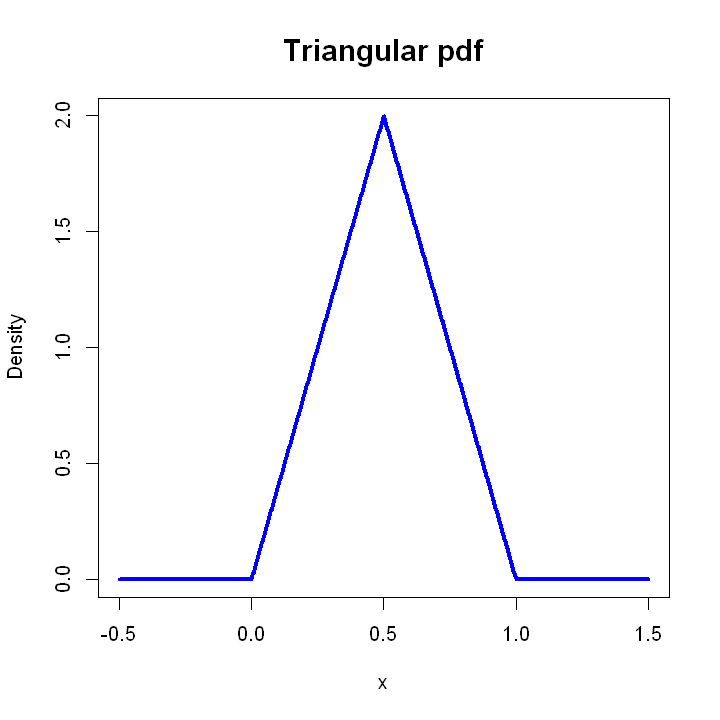

In [2]:
options(repr.plot.width=6,repr.plot.height=6)
x<-seq(-0.5,1.5,length=1000)
plot(x,f(x),type="l",lwd=3.5,col="blue",xlab="x",ylab="Density",main="Triangular pdf",cex.main=1.5)

#### cdf  for the triangular pdf

$$
    F(x)=\left\{\begin{array}{lll}
    0,                 &\text{ if }    &x<0,\\[0.25cm]
    2\,x^{2},          &\text{ if }    &0\leq x<1/2,\\[0.25cm]
    -1+4\,x-2\,x^{2},  &\text{ if }    &1/2\leq x<1,\\[0.25cm]
    1,                 &\text{ if }    &1\leq x,
    \end{array}\right.\mskip60mu x\in\R.
$$

In [3]:
F<-function(x){
    ifelse(x<0,0,ifelse(x<0.5,2*x^2,ifelse(x<1,-1+4*x-2*x^2,1)))
    }

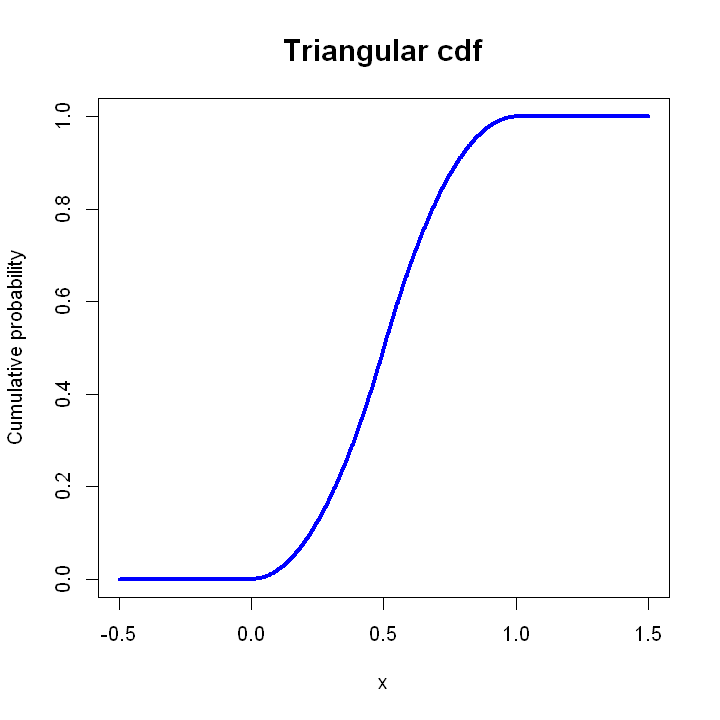

In [4]:
options(repr.plot.width=6,repr.plot.height=6)
x<-seq(-0.5,1.5,length=1000)
plot(x,F(x),type="l",lwd=3.5,col="blue",xlab="x",ylab="Cumulative probability",main="Triangular cdf",cex.main=1.5)

#### Quantile function for the triangular pdf

$$
    Q(y)=\left\{\begin{array}{lll}
    \sqrt{y/2},         &\text{ if }    &y\in(0,1/2),\\[0.25cm]
    1-\sqrt{(1-y)/2},   &\text{ if }    &y\in(1/2,1],
    \end{array}\right.\mskip50mu y\in(0,1]
$$

In [5]:
Q<-function(y){
    ifelse(y<0.5,sqrt(y/2),1-sqrt((1-y)/2))
    }

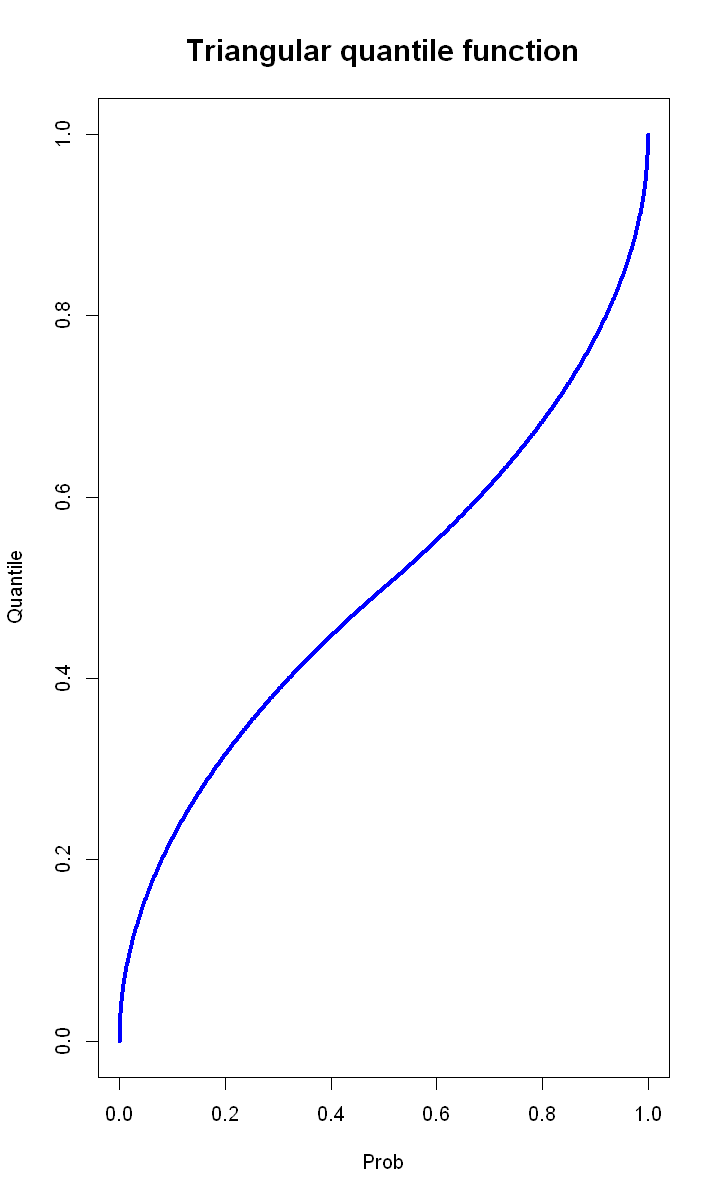

In [6]:
options(repr.plot.width=6,repr.plot.height=10)
y<-seq(0,1,length=1000)
plot(y,Q(y),type="l",lwd=3.5,col="blue",xlab="Prob",ylab="Quantile",main="Triangular quantile function",cex.main=1.5)

In [7]:
rtriang<-function(n){
    return(Q(runif(n)))
    }

In [8]:
n<-5.0e4
x<-rtriang(n)

In [9]:
str(x)

 num [1:50000] 0.296 0.565 0.627 0.491 0.373 ...


In [10]:
options(repr.plot.width=6,repr.plot.height=6)
hist(x,main="Random numbers for the triangular pdf",freq=FALSE,xlim=c(-0.2,1.2),ylim=c(0,2.1),nclass=70,col="LightSkyBlue",cex.main=1.5)
u<-seq(0,1,length=1000)
lines(u,f(u),lwd=3.5,col="blue")

# Using Stan

## 00 - Load `rstan` 

The R package to communicate with Stan.

In [11]:
#install.packages("rstan", dependencies=TRUE,repos= "https://cloud.r-project.org")
require(rstan)

Loading required package: rstan

Loading required package: StanHeaders

Loading required package: ggplot2

rstan (Version 2.21.3, GitRev: 2e1f913d3ca3)

For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)

Do not specify '-march=native' in 'LOCAL_CPPFLAGS' or a Makevars file



In [12]:
# Following directions:
# For execution on a local, multicore CPU with excess RAM we recommend calling
# options(mc.cores = parallel::detectCores()).
# To avoid recompilation of unchanged Stan programs, we recommend calling
# rstan_options(auto_write = TRUE)
parallel::detectCores()
options(mc.cores = parallel::detectCores())
rstan_options(auto_write = TRUE)

[1] 8

## 01 - Write Stan code

In [13]:
Triang_codeString <- "
    functions {
       real Q(real u){
            if (u<0.5)     return sqrt(u/2);
            else if (u<1)  return 1-sqrt((1-u)/2);
            else return 0;
            }
        real triang_rng(){
            real u;
            u = uniform_rng(0, 1);
            return Q(u);  
            }
        
    }
    //data{}
    //transformed data {}
    //parameters{}
    //transformed parameters {}
    //model{ }
    generated quantities{
        real y;
        y = triang_rng();  
        }
"

## 02 - Generate a DSO

(A Dynamic Shared Object, e.g., a DLL in Windows)

In [14]:
Triang_stanDSO <- stan_model( model_code=Triang_codeString ) 

## 03 - Enter data (if any), specify runtime quantities (if any), and execute the code

For this model, the sampler must be configured to use the `"fixed-parameters"` setting because there are no parameters.

Without parameter sampling there is no need for adaptation and the number of warmup iterations should be set to zero 

(See section 15.3. _Sampling without parameters_ in the Reference manual 2.29, pag. 180).

In [15]:
# Specify data:
dataList <- NULL

In [16]:
# Generate posterior sample:
Triang_stanFit <- sampling( object=Triang_stanDSO, 
                     data = dataList, algorithm="Fixed_param",
                     chains = 1, seed = 24025, iter = 10000, warmup = 0, thin = 1)


SAMPLING FOR MODEL 'ed0c4c06357d457fbf9a7abd58a04f18' NOW (CHAIN 1).
Chain 1: Iteration:    1 / 10000 [  0%]  (Sampling)
Chain 1: Iteration: 1000 / 10000 [ 10%]  (Sampling)
Chain 1: Iteration: 2000 / 10000 [ 20%]  (Sampling)
Chain 1: Iteration: 3000 / 10000 [ 30%]  (Sampling)
Chain 1: Iteration: 4000 / 10000 [ 40%]  (Sampling)
Chain 1: Iteration: 5000 / 10000 [ 50%]  (Sampling)
Chain 1: Iteration: 6000 / 10000 [ 60%]  (Sampling)
Chain 1: Iteration: 7000 / 10000 [ 70%]  (Sampling)
Chain 1: Iteration: 8000 / 10000 [ 80%]  (Sampling)
Chain 1: Iteration: 9000 / 10000 [ 90%]  (Sampling)
Chain 1: Iteration: 10000 / 10000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 0 seconds (Warm-up)
Chain 1:                0.009 seconds (Sampling)
Chain 1:                0.009 seconds (Total)
Chain 1: 


## The resulting `stanFit` object contains all the information

The line below is usually commented due to its long output

In [17]:
str(Triang_stanFit)

Formal class 'stanfit' [package "rstan"] with 10 slots
  ..@ model_name: chr "ed0c4c06357d457fbf9a7abd58a04f18"
  ..@ model_pars: chr [1:2] "y" "lp__"
  ..@ par_dims  :List of 2
  .. ..$ y   : num(0) 
  .. ..$ lp__: num(0) 
  ..@ mode      : int 0
  ..@ sim       :List of 12
  .. ..$ samples    :List of 1
  .. .. ..$ :List of 2
  .. .. .. ..$ y   : num [1:10000] 0.5058 0.1487 0.8723 0.718 0.0688 ...
  .. .. .. ..$ lp__: num [1:10000] 0 0 0 0 0 0 0 0 0 0 ...
  .. .. .. ..- attr(*, "test_grad")= logi FALSE
  .. .. .. ..- attr(*, "args")=List of 16
  .. .. .. .. ..$ append_samples    : logi FALSE
  .. .. .. .. ..$ chain_id          : num 1
  .. .. .. .. ..$ control           :List of 11
  .. .. .. .. .. ..$ adapt_delta      : num 0.8
  .. .. .. .. .. ..$ adapt_engaged    : logi FALSE
  .. .. .. .. .. ..$ adapt_gamma      : num 0.05
  .. .. .. .. .. ..$ adapt_init_buffer: num 75
  .. .. .. .. .. ..$ adapt_kappa      : num 0.75
  .. .. .. .. .. ..$ adapt_t0         : num 10
  .. .. .. .. ..

## 04 - Extract random numbers

In [18]:
y<-extract(Triang_stanFit,par="y")$y

In [19]:
str(y)

 num [1:10000(1d)] 0.677 0.146 0.346 0.712 0.338 ...
 - attr(*, "dimnames")=List of 1
  ..$ iterations: NULL


In [20]:
# Discard the unneeded attribute
attr(y,"dimnames")<-NULL
str(y)

 num [1:10000(1d)] 0.677 0.146 0.346 0.712 0.338 ...


In [21]:
options(repr.plot.width=6,repr.plot.height=6)
hist(x,main="Random numbers for the triangular pdf",freq=FALSE,xlim=c(-0.2,1.2),ylim=c(0,2.1),nclass=70,col="LightSkyBlue",cex.main=1.5)
u<-seq(0,1,length=1000)
lines(u,f(u),lwd=3.5,col="blue")